# Exploration - NASA JetEngine Failure Analysis

## Objective of this Notebook
- Introduce the Weibull time to event recurrent neural network (WTTE-RNN)
- Train the NN and do basic convergence checks

The algorithm we apply to the problem does not try to predict the TTE direcly. Instead the trick is to let a machine learning model output the parameters of a probability distribution of event times. In principle this could be any distibution, by adapting the likelihood function. However the **Weibull distribution** is a very good fit for event time prediction. The distribution has a long history of different applications, eg.:

- In survival analysis
- In reliability engineering and failure analysis
- In electrical engineering to represent overvoltage occurring in an electrical system
- In industrial engineering to represent manufacturing and delivery times
- In extreme value theory
- In weather forecasting and the wind power industry to describe wind speed distributions, as the natural distribution often matches the Weibull shape
- In communications systems engineering
- In general insurance to model the size of reinsurance claims, and the cumulative development of asbestosis losses
- In forecasting technological change (also known as the Sharif-Islam model)
- ... and a lot more

In principle a lot of different machine learning algorithms could be used to estimate the Weibull parameters, but in this example we apply **Recurrent Neural Networks (RNN)**.

![Weibull Time To Event RNN](imgs/fig_rnn_weibull.png)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import Adam
from keras.callbacks import History, TerminateOnNaN, ReduceLROnPlateau
from keras import backend as k

np.random.seed(2)
np.set_printoptions(suppress=True, threshold=10)
pd.set_option("display.max_rows",100)

Using TensorFlow backend.


The key to fit the very general RNN model together with the problem or domain-specific Weibull model is an adapted likelihood function. To be more specific in our case we propose a discrete log-likelihood for Weibull hazard function on censored survival data, where $y_{\mathrm{true}}$ is a $(N_{\mathrm{samples}}, 2)$ tensor, containing time-to-event vector $y$, and an event indicator $u$. The vector $ab_{\mathrm{pred}}$ containes the predictions for the distribution parameters $\alpha$ and $\beta$. For a detailed derivation we point to the master thesis of *Egil Martinsson (2016)*.

In [2]:
def weibull_discrete_loglikelihood(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus

In [3]:
def mixed_func_activation(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

## Data prepariation
Load and parse engine data files into:
   - an (engine/day, observed history, sensor readings) x tensor, where observed history is 100 days, zero-padded
     for days that don't have a full 100 days of observed history (e.g., first observed day for an engine)
   - an (engine/day, 2) tensor containing time-to-event and 1 (since all engines failed)
There are probably MUCH better ways of doing this, but I don't use Numpy that much, and the data parsing isn't the
point of this demo anyway.

In [4]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [5]:
base_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master//prepared_data/nasa_jetengine/"
train = pd.read_csv(base_path + 'train.csv.gz', header=None, names=column_names)
test_x = pd.read_csv(base_path + 'test_x.csv.gz', header=None, names=column_names)
test_y = pd.read_csv(base_path + 'test_y.csv.gz', header=None, names=['T'])

Text(0,0.5,'unit number')

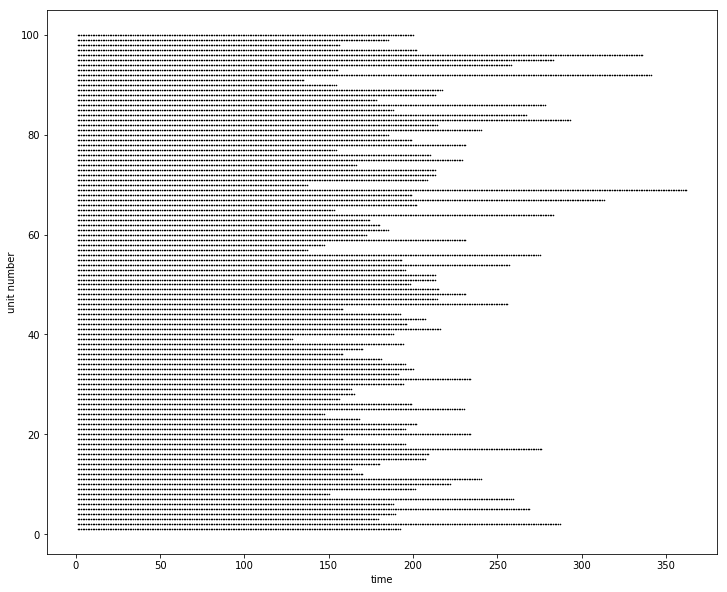

In [6]:
plt.figure(figsize=(12, 10))
plt.scatter(x=train[time_col], y=train[id_col], linewidths=0, color='black', s=2.5)
plt.xlabel("time")
plt.ylabel("unit number")

In [7]:
from sklearn.preprocessing import normalize

# Combine the X values to normalize them, then split them back out
all_x = pd.concat((train[feature_cols], test_x[feature_cols]))
all_x = normalize(all_x, axis=0)

train[feature_cols] = all_x[:train.shape[0], :]
test_x[feature_cols] = all_x[train.shape[0]:, :]

# Make engine numbers and days zero-indexed, for everybody's sanity
train[[id_col, time_col]] -= 1
test_x[[id_col, time_col]] -= 1

In [8]:
# Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

def tranform_data_to_tensors(engine, time, x, max_time, is_test):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = np.empty((0, 2), dtype=np.float32)
    # A full history of sensor readings to date for each x
    out_x = np.empty((0, max_time, len(feature_cols)), dtype=np.float32)

    for i in range(100):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1
        start = max_engine_time - 1 if is_test else 0
        this_x = np.empty((0, max_time, len(feature_cols)), dtype=np.float32)

        for j in range(start, max_engine_time):
            engine_x = x[engine == i]

            out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

            xtemp = np.zeros((1, max_time, len(feature_cols)))
            xtemp += mask_value
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x = np.concatenate((this_x, xtemp))

        out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

In [9]:
X_train, Y_train = tranform_data_to_tensors(train[id_col].values, train[time_col].values, train[feature_cols].values, max_time, is_test=False)
X_test, _ = tranform_data_to_tensors(test_x[id_col].values, test_x[time_col].values, test_x[feature_cols].values, max_time, is_test=True)

u_train = np.zeros((100, 1), dtype=np.float32)
u_train += 1
Y_test = np.append(np.reshape(test_y.values, (100, 1)), u_train, axis=1)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(20631, 100, 24)
(20631, 2)
(100, 100, 24)
(100, 2)


In [11]:
# Start building our model
model = Sequential()
# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(max_time, len(feature_cols))))
# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(LSTM(20, input_shape=(len(feature_cols), None)))
# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))
# Apply the custom activation function mentioned above
model.add(Activation(mixed_func_activation))
# Use the discrete log-likelihood for Weibull survival data as our loss function
model.compile(loss=weibull_discrete_loglikelihood, 
              optimizer=Adam(lr=0.01,clipvalue=0.5))

In [12]:
! sudo pip install pydotplus

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


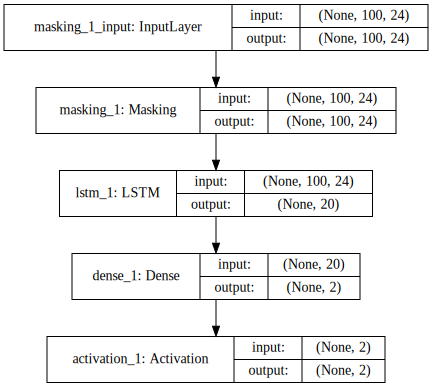

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [18]:
from wtte.wtte import WeightWatcher

run_fit = False
if run_fit:
    history = History()
    weightwatcher = WeightWatcher()
    nan_terminator = TerminateOnNaN()
    reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                  factor  =0.5, 
                                  patience=50, 
                                  verbose=1, 
                                  mode='auto', 
                                  epsilon=0.0001, 
                                  cooldown=0, 
                                  min_lr=1e-8)
    # Fit!
    model.fit(X_train, Y_train, epochs=150, batch_size=5000, verbose=1, validation_data=(X_test, Y_test), 
              callbacks=[history, weightwatcher, nan_terminator, reduce_lr])
    model.save_weights("../prepared_data/nasa_jetengine/wtte_rnn_weights.h5")
    
    # summarize history for loss
    plt.figure(figsize=(20, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    weightwatcher.plot()
else:
    model.load_weights("../prepared_data/nasa_jetengine/wtte_rnn_weights.h5")

## Results

### Overall evaluation
After training this model on the NASA JetEngine failure data, we test it by we picking another set of $100$ engines. This time we want to test the accuracy once for each engine. The test dataset provides already truncated versions of the test time-series with the remaining time-to-failure as external information.

In [25]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(X_test)
test_predict = np.resize(test_predict, (100, 2))

# TTE, Event Indicator, Alpha, Beta
test_results = pd.DataFrame(np.concatenate((Y_test, test_predict), axis=1), columns=['T', 'E', 'alpha', 'beta'])
test_results['unit_number'] = np.arange(1, test_results.shape[0]+1)
test_results.head()

,T,E,alpha,beta,unit_number
0,112.0,1.0,204.146744,4.004395,1
1,98.0,1.0,174.233856,3.500005,2
2,69.0,1.0,72.865257,1.244724,3
3,82.0,1.0,83.590904,1.514334,4
4,91.0,1.0,82.541756,1.489470,5


In [26]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

If we look at the distribution of $T$ in the test set and the mean of Weibull parameters we can immediately check if our model does make sense. The following plot shows that the mean Weibull distribution overlaps the true distribution.

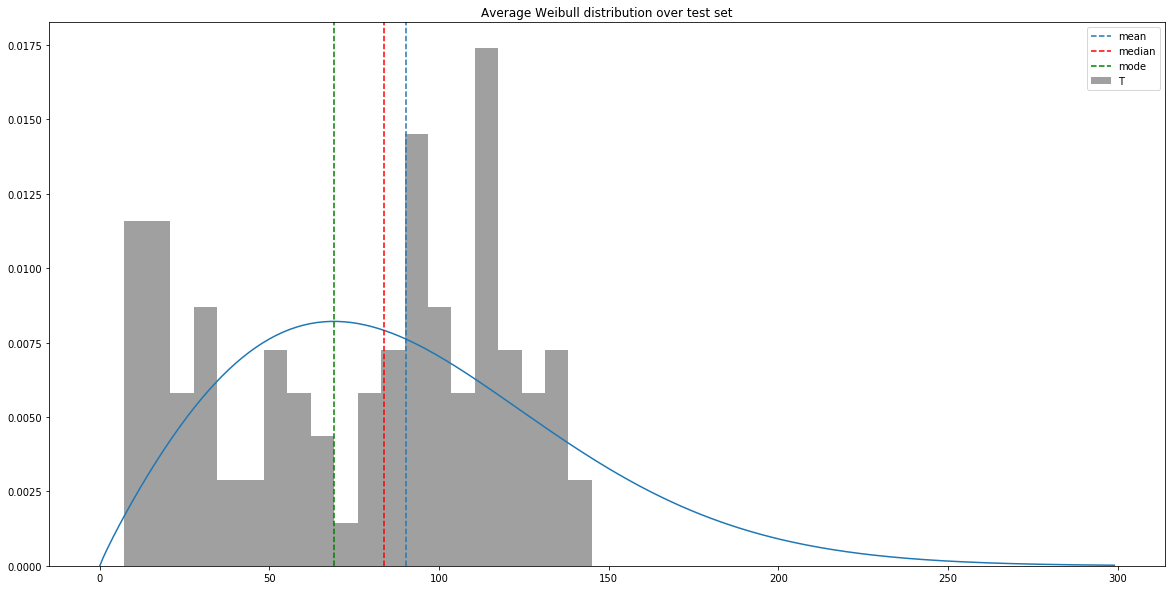

In [27]:
t = np.arange(0,300)
alpha = test_results['alpha'].mean()
beta = test_results['beta'].mean()
mu = weibull_mean(alpha, beta)
median = weibull_median(alpha, beta)
mode =  weibull_mode(alpha, beta)

test_results['predicted_mu'] = test_results[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results['predicted_median'] = test_results[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results['predicted_mode'] = test_results[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)
test_results['error'] = test_results['T'] - test_results['predicted_median']

plt.figure(figsize=(20, 10))
plt.plot(t, weibull_pdf(alpha, beta, t))
n, bins, patches = plt.hist(test_results['T'], bins=20, density=True, facecolor='grey', alpha=0.75, label='T')
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
plt.legend()
plt.title('Average Weibull distribution over test set');

In the following we plot a subset of the Weibull distributions of each of individual engines in the test set and marking with a dot the corresponding true value. One can observe that most of the true values are close to the mode of the distribution (each color represents a different engine):

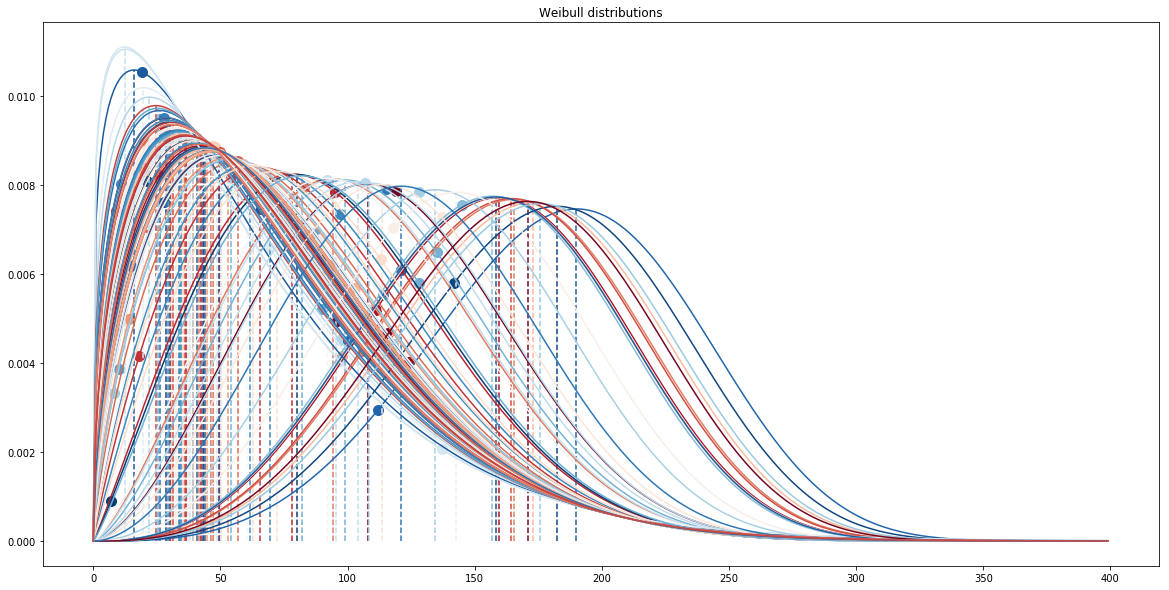

In [63]:
plot_size = 100
palette = sns.color_palette("RdBu", plot_size + 1)
color_dict = dict(enumerate(palette))

t = np.arange(0,400)
omega = list(np.random.choice(np.arange(len(test_results)), size=plot_size, replace=False))
plt.figure(figsize=(20, 10))
plt.title('Weibull distributions')
for i, row in enumerate(test_results.iterrows()):
    if not i in omega: continue
    color = color_dict[omega.index(i)]
    
    alpha = row[1]['alpha']
    beta = row[1]['beta']
    T = row[1]['T']
    mode = weibull_mode(alpha, beta)
    y_max = weibull_pdf(alpha, beta, mode)
    
    plt.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
    plt.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
    plt.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

If we woul like to treat this problem as a regression we could use the mode, or alternatively the expected value (mean), of the distribution and compare the error in time. The following figure shows a regression scatter plot showing the predicted value vs. the true target:

Text(23.875,0.5,'Actual remaining useful life')

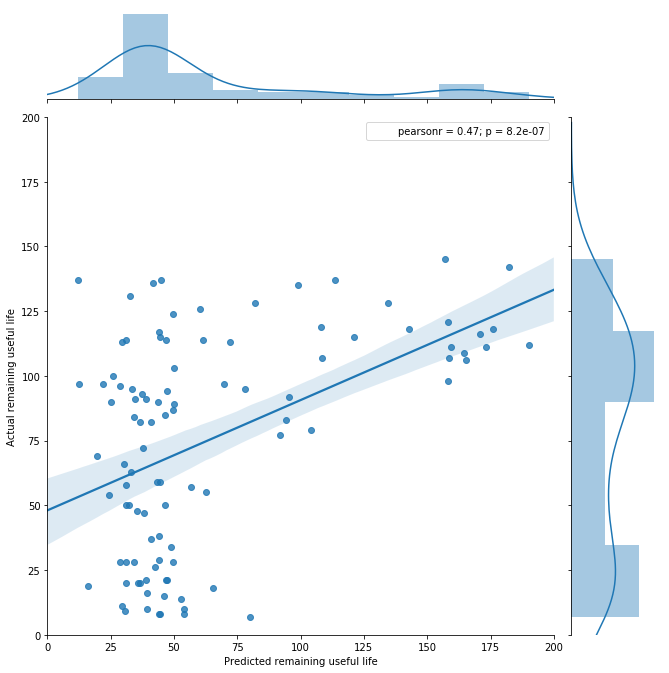

In [65]:
grid = sns.jointplot(data=test_results, y='T', x='predicted_mode', kind="reg",
                     xlim=(0, 200), ylim=(0, 200))
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)
plt.xlabel("Predicted remaining useful life")
plt.ylabel("Actual remaining useful life")

In [23]:
test_results['error'].describe()

count    100.000000
mean      -8.226457
std       39.921602
min      -84.078902
25%      -42.904236
50%      -10.686913
75%       25.202591
max       86.474862
Name: error, dtype: float64

The distribution of residual error will look like: 

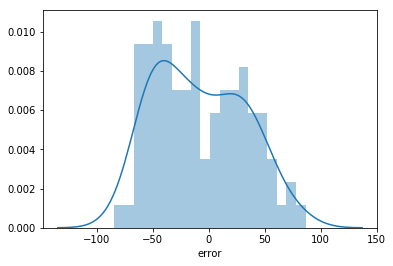

In [24]:
sns.distplot(test_results['error'], bins=20)

### One individual analysis
It looks like the residuals belong to a family of non Normal distributions. The nice result is that the residual error has almost zero mean, aka. unbiased predictions.

Nevertheless, treating the Weibull distribution as a single prediction means losing all of its probabilistic charme. Thus, it is more advisable to reason about your time-to-failure in probabilistic terms or at least to provide some confidence intervals.

If, instead, we pick the engine number 3 from the test set and predict all of its sub-sequences (from 1 to the latest observation), we can see the evolution of the predicted time-to-failure distributions at each time step (blu is the beginning and red is the end of the sequence):

In [ ]:
# TODO

As we approach the real failure the expected time-to-failure gets smaller but also the variance of our prediction become tinier. This is a another evidence that the model learns the correct failure dynamics.

If we plot the predictions at each time step of engine 3 in terms of mode and $[10\%, 90\%]$ confidence interval we observe the following:

In [ ]:
# TODO

This is a very powerful resource to take into account into predictive modeling: you can decide what risk you want to take on predicting early failures Vs. too-late detections.